# Novelty

In [1]:
from koselleck import *

In [168]:
def do_get_novelty(word,**kwargs):
    return test_novelty(get_historical_semantic_distance_matrix(
            word,
            interpolate=True,
            normalize=True
        ),
        **kwargs
    ).assign(word=word)

def get_novelty(words=None,interpolate=True,by_word=True,progress=False, lim=None, num_proc=1, **y):
    if words is None: words=get_valid_words()
    words=tokenize_fast(words) if type(words)==str else words
    if os.path.exists(FN_NOV_ALL_BYWORD):
        odf=get_all_novelty_scores(by_foote_size=True)
        odf=odf[odf.word.isin(words)]
        if not by_word: odf=odf.groupby(['foote_size','period']).mean().reset_index()
        return odf
    else:
        if by_word:
            o=pmap(
                do_get_novelty,
                words[:lim],
                progress=progress,
                desc='Calculating novelty for words',
                num_proc=num_proc
            )
            odf=pd.concat(o) if len(o) else pd.DataFrame()
        else:
            distdf=get_historical_semantic_distance_matrix(words,interpolate=interpolate)
            odf=test_novelty(distdf,**y)
        odf['period']=[int(x[:4]) for x in odf.period]
    return odf

In [170]:
get_novelty('virtue,value',by_word=True)

,period,foote_novelty,foote_size,p_peak,p_trough,word,foote_novelty_z
100,1740,2.692189,4,1.00,1.0,value,-0.525692
101,1745,4.522264,4,0.48,1.0,value,0.135949
102,1750,3.659113,4,0.91,1.0,value,-0.176113
103,1755,3.529320,4,0.91,1.0,value,-0.223038
104,1760,2.949576,4,1.00,1.0,value,-0.432637
...,...,...,...,...,...,...,...
229,1905,8.042206,6,0.57,1.0,virtue,-0.240696
230,1910,10.422168,6,0.02,1.0,virtue,0.176976
231,1915,9.391275,6,0.15,1.0,virtue,-0.003941
232,1920,8.446556,6,0.46,1.0,virtue,-0.169735


In [171]:
# get_novelty('station', by_word=False).query('foote_novelty!=0')

In [172]:
# nov_all_mean=get_novelty(by_word=False)
# nov_all_mean

In [173]:
def get_all_novelty_scores(ifnfn=FN_NOV_ALL_BYWORD,
                           by_foote_size=False, min_foote_size=4, max_foote_size=6):
    global DFALLNOV
    if DFALLNOV is not None:
        odf=DFALLNOV
    elif not os.path.exists(ifnfn):
        print(f'Generating novelty scores, saving to {ifnfn}')
        DFALLNOV = odf = nov_all_byword = get_novelty(by_word=True,progress=True,num_proc=1)
        nov_all_byword.to_pickle(FN_NOV_ALL_BYWORD)
    else:
        print(f'Loading novelty scores from {ifnfn}')
        DFALLNOV=odf=read_df(ifnfn)
        
    odf = odf.query(f'foote_novelty!=0 & {min_foote_size}<=foote_size<={max_foote_size}')
    odf = pd.concat(
        grp.assign(
            foote_novelty_z=(grp.foote_novelty - grp.foote_novelty.mean()) / grp.foote_novelty.std()
        )
        for i,grp in odf.groupby('foote_size')
    )
    if not by_foote_size:
        odf=odf.groupby(['word','period']).mean().drop('foote_size',1).reset_index()
    else:
        odf['foote_size']=odf.foote_size.apply(int)
    return odf
        


In [174]:
get_all_novelty_scores(by_foote_size=True)

,period,foote_novelty,foote_size,p_peak,p_trough,word,foote_novelty_z
90,1765,2.472151,4,1.00,1.00,recollection,-0.605244
91,1770,4.423152,4,0.85,1.00,recollection,0.100116
92,1775,2.624945,4,1.00,1.00,recollection,-0.550003
93,1780,0.746535,4,1.00,0.04,recollection,-1.229119
94,1785,2.954981,4,1.00,1.00,recollection,-0.430683
...,...,...,...,...,...,...,...
224,1905,12.817505,6,0.37,1.00,inference,0.597346
225,1910,12.671342,6,0.41,1.00,inference,0.571695
226,1915,13.574138,6,0.24,1.00,inference,0.730131
227,1920,14.853950,6,0.07,1.00,inference,0.954732


In [175]:
def get_signif_novelty_scores(p_peak=0.05,min_peaks=1):
    odf=get_all_novelty_scores().query(f'p_peak<{p_peak}')
    odf=pd.concat(
        grp.assign(
            word_num_peaks=len(grp[grp.p_peak<p_peak])
        ) for i,grp in odf.groupby('word')
    )
    if min_peaks: odf=odf[odf.word_num_peaks>=min_peaks]
    return odf.sort_values('foote_novelty_z',ascending=False)

In [176]:
# get_signif_novelty_scores(
#     p_peak=0.05
# ).groupby('word').mean().sort_values('foote_novelty_z',ascending=False)

In [177]:
def get_all_sign_words(p_peak=0.05,min_peaks=1):
    df=get_all_novelty_scores()
    dfsign=get_signif_novelty_scores(p_peak=p_peak,min_peaks=min_peaks)
    signwset=set(dfsign.word)
    o=[
        w for w in 
        df.groupby('word').mean().sort_values('foote_novelty',ascending=False).index
        if w in signwset
    ]
    print('# all words',len(set(df.word)))
    print('# signif words',len(set(dfsign.word)))
    return o

In [178]:
sign_words = get_all_sign_words(p_peak=0.01)

# all words 6007
# signif words 1437


## Plotting

In [179]:
def get_plot_novelty_figdf(novdf):
    figdf=novdf.sample(frac=1)
    ywl=[
        f'{x} years'
        for x in figdf['foote_size']*5*2
    ]
    ywls=set(ywl)
    ywll=list(reversed(sorted(list(ywls))))
    figdf['year_window']=pd.Categorical(ywl, categories=ywll)
    figdf['glen']=1
    figdf['is_signif']=pd.Categorical(
        [bool(x<0.05) for x in figdf.p_peak],
        categories=[True,False]
    )
    figdf = pd.concat(
        grp.assign(foote_novelty_z=grp.foote_novelty.apply(lambda x: (x-grp.foote_novelty.mean())/grp.foote_novelty.std()))
        for i,grp in figdf.groupby('foote_size')
    )
    return figdf.dropna().sort_values(['year_window','period'])


# @interact
def plot_novelty(
        words=None,
        novdf=None,
        color='factor(year_window)',
        group='factor(year_window)',
        shape='factor(year_window)',
        size='glen',
        max_p_peak=None,
        vnum='v9',
        showdata=False,
        xlab='Date of semantic model',
        ylab='Foote Novelty (standardized)',
        colorlab='Foote matrix width',
        shapelab='Foote matrix width',
        sizelab='Number of significant peaks',
        title='Average novelty score for significant words over time',
        rolling=2,
        min_periods=1,
        min_foote_size=6,
        max_foote_size=6,
        y='foote_novelty',
        ymin=-.1,
        ylim0=0,
        ylim1=20,
        use_ylim=False,
        xlim0=1750,
        xlim1=1900,
        sizemin=.25,
        sizemax=2,
        labsize=6,
        hline='',
        nudge_label_y=1,
        ymin_heatmap=1750,
        combine=False,
        use_color=False,
        h_fig1=4.00,
        h_fig2=4.00,
        nudge_x=3,
        xlab_min=1735,
        add_median=True,
        save=False,
        label_words=False,
        logy=False,
        show_period_labels=True,
        dist_invert_fill=False,
        line_size=0.5,
        label_size=7,
        by_word=False
        ):

    figwords=set(words) if words else {'allwords'}
    if novdf is None:
        if words is None: return
        
        novdf = get_novelty(words,by_word=by_word)
        if not by_word: words=None
        print(f'Computed novelty df of shape {novdf.shape}')
        display(novdf)
        
    figdf=get_plot_novelty_figdf(novdf.query(f'{min_foote_size}<=foote_size<={max_foote_size}'))
    if not len(figdf): return
    if max_p_peak: figdf=figdf[figdf.p_peak<max_p_peak]
    
    
    figdf=figdf.sort_values('period')
#     display(figdf)
    if showdata: display(figdf)
#     print(f'y = {y}')
    fig=start_fig(
        figdf,
        x='period',
        y=y,
        color=color if color else None,
        group=group if group else None,
        figure_size=(8,h_fig1)
    )
    
    if add_median:
        kname='Guides'
        mediandf=pd.DataFrame([{
            'yintercept':figdf[y].median(),
            kname:'Median',
        },
#         {
#             'yintercept':0,
#             kname:'Zero novelty'
#         }
        ])
        fig+=p9.geom_hline(
            p9.aes(yintercept='yintercept',linetype=kname),
            data=mediandf,
            size=.25,
            show_legend=True
        )
        #fig+=p9.geom_text(inherit_aes=False,y=figdf[y].median()+.1,x=xlab_min,size=6,alpha=.8,ha='center',label='Median')
    
            
    fig+=p9.geom_line(size=line_size)
    pntd={}
    if size: pntd['size']=size
    if shape: pntd['shape']=shape
    fig+=p9.geom_point(p9.aes(**pntd))
    # fig+=p9.geom_smooth()
#     fig+=p9.scale_color_distiller()
    
    
    fig+=p9.labs(x=xlab,y=ylab,title=title,color=colorlab,size=sizelab,shape=shapelab)
    if use_ylim: fig+=p9.ylim(ylim0,ylim1)
#     fig+=p9.xlim(xlim0,xlim1)
    fig+=p9.scale_size_continuous(range=(sizemin,sizemax))
    if not use_color: fig+=p9.scale_color_gray(direction=1)# if not use_color else p9.scale_color_distiller(type='qual')
    if hline not in {None,''}:
        fig+=p9.geom_hline(yintercept=hline,linetype='dotted')
#     fig+=p9.geom_smooth(p9.aes(x='year',y=y),inherit_aes=False)

    if words and label_words:
        labeldf=figdf[figdf.is_signif==1]
        grps=[
            grp.sort_values(y).iloc[-1:]
            for i,grp in labeldf.groupby('word')
        ]
        if len(grps):
            labeldf=pd.concat(grps)
            labeldf[y]+=nudge_label_y
            fig+=p9.geom_label(p9.aes(label='word'),color='black',
                               size=label_size,data=labeldf,boxcolor=(0,0,0,0))


    if show_period_labels:
        fig+=p9.geom_vline(xintercept=1770,linetype='dotted',alpha=0.5) 
        fig+=p9.geom_vline(xintercept=1800,linetype='dotted',alpha=0.5) 
        fig+=p9.geom_vline(xintercept=1830,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1750,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1850,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1789,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1815,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1848,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1830,linetype='dashed')
#     if False:
        fig+=p9.geom_label(label='Sattelzeit begins (1770)',x=1770+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0))
        fig+=p9.geom_label(label='Sattelzeit ends (1830)',x=1830+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
#         fig+=p9.geom_label(label='French Rev. (1789)',x=1789+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
#         fig+=p9.geom_label(label='Peak semantic change (1815)',x=1815+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
#         fig+=p9.geom_label(label='Revolutions of 1848',x=1848+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
    
    
    

    
    
#     fig+=p9.geom_vline(xintercept=1789,linetype='dotted',alpha=0.5) 
#     fig+=p9.geom_vline(xintercept=1815,linetype='dotted',alpha=0.5) 
#     fig+=p9.geom_vline(xintercept=1830,linetype='dashed')
    

#     xlim0,xlim1=figdf.year.min()//10*10,figdf.year.max()
    if size=='is_signif':
        fig+=p9.scale_size_manual({True:2,False:.2})
    else:
        fig+=p9.scale_size_continuous(range=[.25,3])
#     fig+=p9.scale_x_continuous(breaks=10)
    fig+=p9.theme_minimal()
    fig+=p9.theme(axis_text_x=p9.element_text(angle=90), text=p9.element_text(size=8))
#     if not use_ylim:
#         ylim0=figdf[y].dropna().min()
#         ylim1=figdf[y].dropna().max()
    if logy: fig+=p9.scale_y_log10(limits=[ylim0,ylim1])
        
    
    
    
    #fig+=p9.scale_fill_gray()
    fig+=p9.scale_x_continuous(
        minor_breaks=list(range(xlim0//5*5,(xlim1//5*5)+5,5)),
        limits=[xlim0,xlim1]
    )
#     fig+=p9.xlim(xlim0,xlim1)
    wkey=''
    if words: wkey=words.replace(' ','') if type(words)==str else '-'.join(words)
    ofn=f'''fig.footenov.{vnum}.{wkey+'.' if wkey else ''}{'cmbo.' if combine else ''}png'''
    ofnfn=os.path.join(PATH_FIGS,ofn)

    if combine:
        yymin1=figdf.period.min()
        yymax1=figdf.period.max()
        figdm=plot_historical_semantic_distance_matrix(words=figwords,ymin=xlim0,ymax=xlim1)
        ofig=combine_plots(figdm,fig,ofn=ofnfn)
    else:
        ofig=fig
        if save: ofig.save(ofnfn)
    display(ofig)
    if save: upfig(ofnfn)

## Plotting all significant words' novelties

In [208]:
# def plot_novelty_all(words,**y):
#     title=f'Foote Novelty scores for significant, 1740-1875 (BPO)'
#     return plot_novelty(**{
#         **dict(
#             words=words,
#             min_foote_size=4,
#             max_foote_size=6,
#             rolling=1,
#             max_p_peak=0.05,
#             vnum='v26',
#             xlim0=1750,xlim1=1960,
#             save=False,
#             title=title,
#             size='is_signif',
#             sizelab='Statistically signif.',
#             dist_invert_fill=False,
#             ylab='Foote Novelty',
#             y='foote_novelty_z',
#             ylim1=-3
#         ),
#         **y
#     })


In [209]:
# plot_novelty_all(sign_words)

### Plot all v2

In [187]:
df=get_all_novelty_scores()
df

,word,period,foote_novelty,p_peak,p_trough,foote_novelty_z
0,abandonment,1820,8.296391,0.480000,1.000000,1.500437
1,abandonment,1825,11.794832,0.055000,1.000000,1.967908
2,abandonment,1830,5.873570,1.000000,1.000000,-0.160095
3,abandonment,1835,3.183570,1.000000,0.313333,-0.843477
4,abandonment,1840,2.146910,1.000000,0.546667,-1.028226
...,...,...,...,...,...,...
201452,zoology,1895,9.607818,0.996667,1.000000,0.687583
201453,zoology,1900,8.185602,1.000000,0.670000,0.356552
201454,zoology,1905,6.859207,1.000000,0.446667,0.078104
201455,zoology,1910,6.655696,1.000000,0.510000,0.433965


In [201]:
def get_num_peaks_by_period(p_peak=0.01,min_peaks=1):
    df=get_all_novelty_scores(by_foote_size=True, min_foote_size=2, max_foote_size=6)
    return pd.DataFrame([
        {
            'foote_size':fs,
            'period':period,
            'num_peaks':len(grp.query(f'p_peak<{p_peak}')),
            'avg_nov_signif':grp.query(f'p_peak<{p_peak}').foote_novelty_z.mean(),
            'avg_nov':grp.foote_novelty_z.mean(),
        } for ((fs,period),grp) in df.groupby([
            'foote_size','period'
        ])
    ])

In [202]:
figdf=get_num_peaks_by_period()
figdf

,foote_size,period,num_peaks,avg_nov_signif,avg_nov
0,2,1730,32,0.968983,0.052728
1,2,1735,8,3.010944,0.076936
2,2,1740,4,1.319734,-0.072065
3,2,1745,40,3.139543,0.204082
4,2,1750,21,1.961328,0.197232
...,...,...,...,...,...
195,6,1905,245,3.085766,0.401735
196,6,1910,428,3.083110,0.622310
197,6,1915,385,2.906658,0.661962
198,6,1920,280,2.836463,0.583549


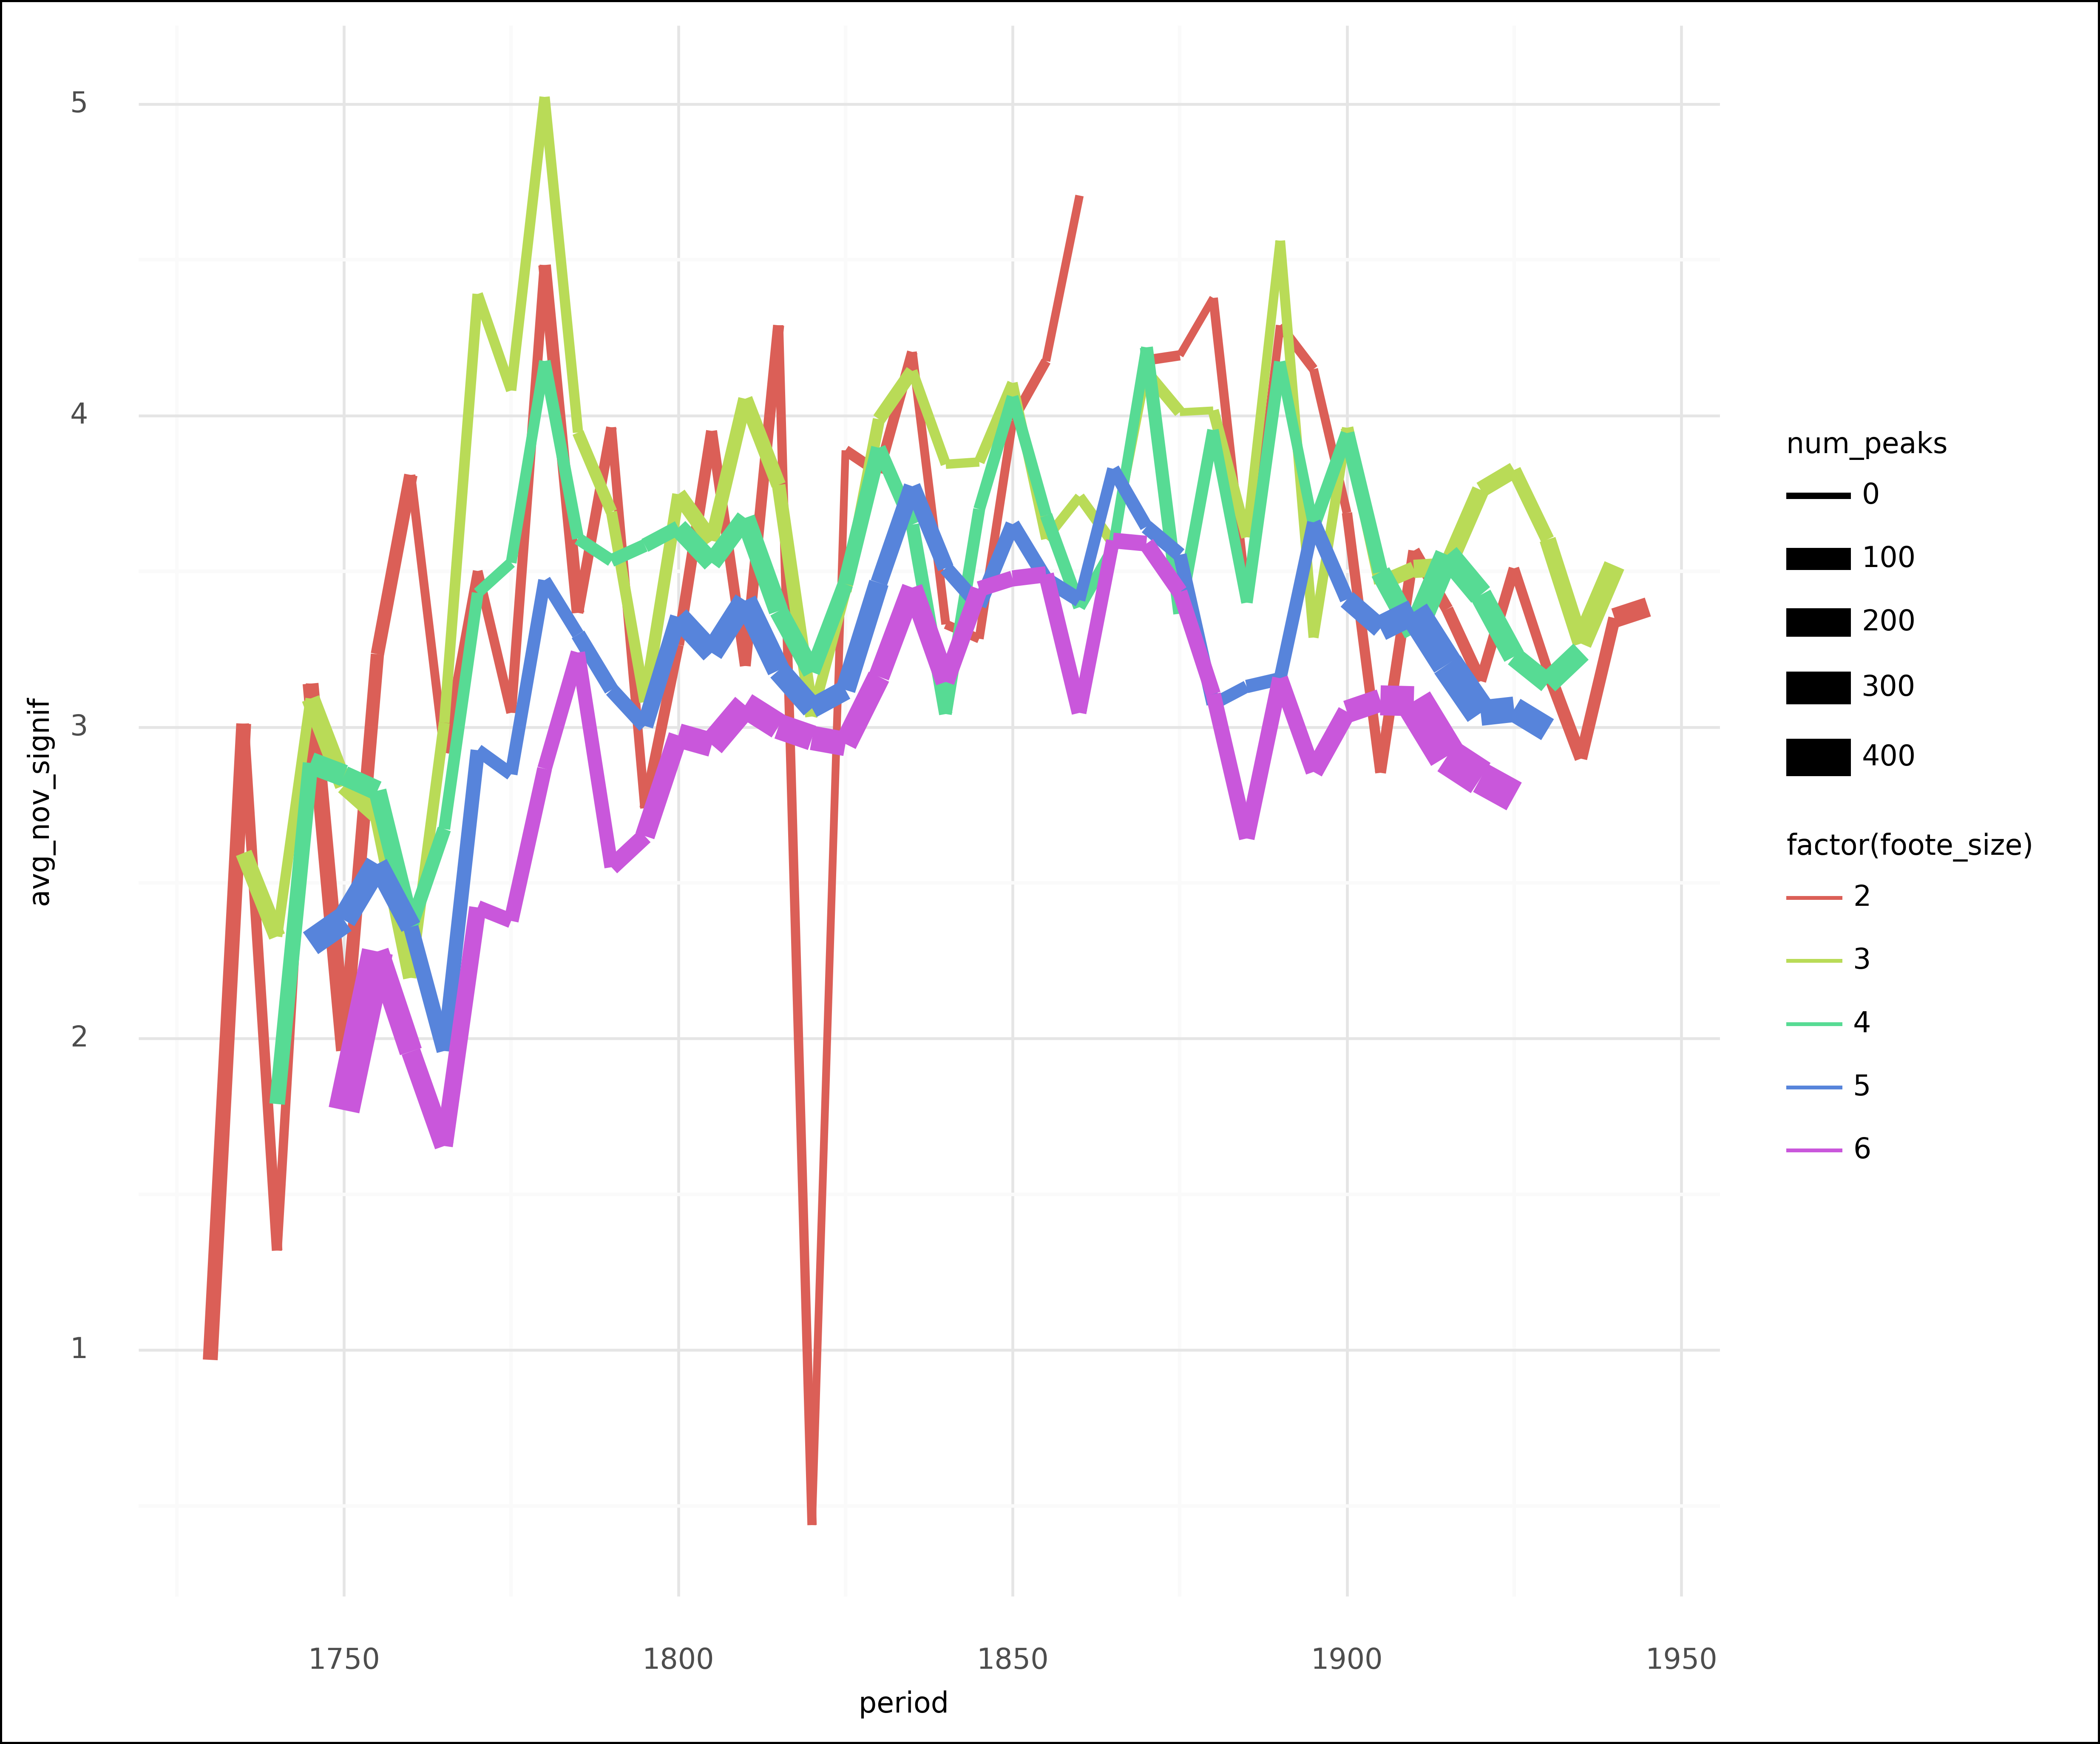

<ggplot: (402183307)>

In [205]:
fig=start_fig(figdf,x='period',y='avg_nov_signif',size='num_peaks',color='factor(foote_size)') + p9.geom_line()
fig

## Plotting individual words

In [146]:
def plot_novelty_words(words,**kwargs):
    inpd=dict(
        y='foote_novelty_z',
        words=words,
        color='word',
        group='word',
        shape='word',
        colorlab='Word',
        shapelab='Word',
        sizelab='Statistically significant',
        title='Novelty scores for key words',
        ylab='Foote Novelty score',
        size='is_signif',
        vnum='v19',
        use_ylim=False,
        add_median=True,
        max_p_peak=0.0,
        min_foote_size=5,
        max_foote_size=5,
        showdata=False,
        nudge_x=2,
        logy=False,
        ylim0=0,
        ylim1=10,
        xlim0=1745,
        xlim1=1870,
        rolling=2,
        ymin=.1,
        label_words=True,
        show_period_labels=True,
        nudge_label_y=0.25,
        save=True
    )
    return plot_novelty(**{**inpd, **kwargs})


In [ ]:
# plot_novelty_words('station,value,commerce,growth,culture,slave,slavery,god,time,december')
plot_novelty_words('station,value,slave,demand,interest,circulation,improvement')